Ссылка на GitHub: [https://github.com/Irina-Balycheva/-Learning-with-a-teacher](https://github.com/Irina-Balycheva/-Learning-with-a-teacher)

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. При этом нужно довести метрику до 0.59. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [5]:
# открываем данные
df = pd.read_csv('C:/Users/dvpav/Desktop/projects/Обучение с учителем/Churn.csv')
display(df.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропущенные значения имеются только в столбце "Tenure". Чтобы не избавляться от 10% данных заменим их на медианное значение, которое более устойчиво к выбросам.  

In [7]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Преобразуем в классы столбец "Gender" и "Geography" путем прямого кодирования, которое подходит для всех наших будущих моделей. Удалим лишние признаки. 

In [8]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

display(df.head(10))


,RowNumber,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male
0,1,15634602,Hargrave,619,France,42,2.0,0.00,1,1,1,101348.88,1,0
1,2,15647311,Hill,608,Spain,41,1.0,83807.86,1,0,1,112542.58,0,0
2,3,15619304,Onio,502,France,42,8.0,159660.80,3,1,0,113931.57,1,0
3,4,15701354,Boni,699,France,39,1.0,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,43,2.0,125510.82,1,1,1,79084.10,0,0
5,6,15574012,Chu,645,Spain,44,8.0,113755.78,2,1,0,149756.71,1,1
6,7,15592531,Bartlett,822,France,50,7.0,0.00,2,1,1,10062.80,0,1
7,8,15656148,Obinna,376,Germany,29,4.0,115046.74,4,1,0,119346.88,1,0
8,9,15792365,He,501,France,44,4.0,142051.07,2,0,1,74940.50,0,1
9,10,15592389,H?,684,France,27,2.0,134603.88,1,1,1,71725.73,0,1


In [9]:
display(df['Geography'].value_counts())

df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

display(df.head(10))

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1
5,6,15574012,Chu,645,44,8.0,113755.78,2,1,0,149756.71,1,1,0,1
6,7,15592531,Bartlett,822,50,7.0,0.00,2,1,1,10062.80,0,1,0,0
7,8,15656148,Obinna,376,29,4.0,115046.74,4,1,0,119346.88,1,0,1,0
8,9,15792365,He,501,44,4.0,142051.07,2,0,1,74940.50,0,1,0,0
9,10,15592389,H?,684,27,2.0,134603.88,1,1,1,71725.73,0,1,0,0


In [10]:
# изменим типы данных на int
df['Geography_Germany'] = df['Geography_Germany'].astype(np.float)
df['Geography_Spain'] = df['Geography_Spain'].astype(np.float)
df['Gender_Male'] = df['Gender_Male'].astype(np.float)
df['Exited'] = df['Exited'].astype(np.float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   Surname            10000 non-null  object 
 3   CreditScore        10000 non-null  int64  
 4   Age                10000 non-null  int64  
 5   Tenure             10000 non-null  float64
 6   Balance            10000 non-null  float64
 7   NumOfProducts      10000 non-null  int64  
 8   HasCrCard          10000 non-null  int64  
 9   IsActiveMember     10000 non-null  int64  
 10  EstimatedSalary    10000 non-null  float64
 11  Exited             10000 non-null  float64
 12  Gender_Male        10000 non-null  float64
 13  Geography_Germany  10000 non-null  float64
 14  Geography_Spain    10000 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.1+ MB


C:\Users\dvpav\AppData\Local\Temp/ipykernel_7364/4080508757.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['Geography_Germany'] = df['Geography_Germany'].astype(np.float)
C:\Users\dvpav\AppData\Local\Temp/ipykernel_7364/4080508757.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['Geography_Spain'] = df['Geography_Spain'].ast

In [11]:
df = df.drop(['RowNumber','Surname', 'CustomerId'], axis=1)


## Исследование задачи

Посмотрим количество клиентов, ушедших и оставшихся в банке:

In [12]:
display(df['Exited'].value_counts())

0.0    7963
1.0    2037
Name: Exited, dtype: int64

Имеется дисбаланс классов, так как количество ушедших и оставшихся в банке клиентов далеко от соотношения 1:1, фактически 1:4.

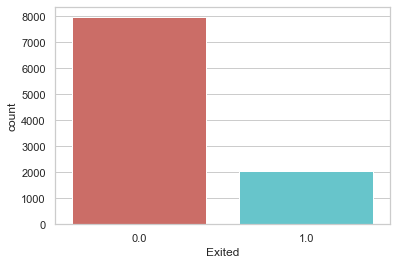

In [13]:
sns.countplot(x='Exited', data=df, palette='hls')
plt.show()

Разобьем выборку на тренировочную, валидационную и тестовую


In [14]:
# разобьем выборку на тренировочную, валидационную и тестовую
features = df.drop('Exited', axis=1)
target = df['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state=12345)
# разбиваем оставшиеся 40% данных пополам (по 20%) на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [15]:
def function_name(model, features_train, target_train, features_valid, target_valid, threshold=0.5):
    THRESHOLD = threshold
    model.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:,1]  
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    display('F1-мера, объединяющая полноту и точность, составила:', f1)
    display('Построим матрицу ошибок:')
    array_confusion_matrix = confusion_matrix(target_valid, predicted_valid)
    array_confusion_matrix_errors = array_confusion_matrix[0][1] + array_confusion_matrix[1][0]
    array_confusion_matrix_true = array_confusion_matrix[0][0] +  array_confusion_matrix[1][1]
    display(array_confusion_matrix)
    display('Ошибочных предсказаний', array_confusion_matrix_errors, 
            'Верных предсказаний', array_confusion_matrix_true, 
            'В', array_confusion_matrix_errors * 100 / array_confusion_matrix_true, '% случаев модель ошибается.')
    
    fp2, tp2, thresholds = roc_curve(target_valid, probabilities_one_valid)
    auc = roc_auc_score(target_valid, probabilities_one_valid)
    display ('ROC-AUC =', auc)
    display('Построим ROC-кривую:')
    plt.figure()
    plt.plot(fp2, tp2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.show()
    return f1, auc

### Логистическая регрессия

Обучим модель без учёта дисбаланса.

'F1-мера, объединяющая полноту и точность, составила:'

0.08385744234800838

'Построим матрицу ошибок:'

array([[1543,   39],
       [ 398,   20]], dtype=int64)

'Ошибочных предсказаний'

437

'Верных предсказаний'

1563

'В'

27.959053103007037

'% случаев модель ошибается.'

'ROC-AUC ='

0.6727947180904797

'Построим ROC-кривую:'

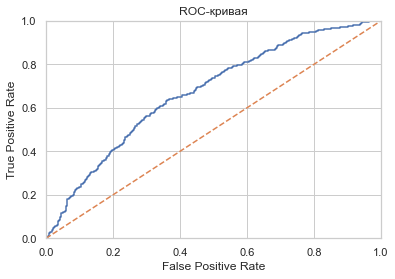

In [16]:
model = LogisticRegression(random_state=12345, solver='liblinear')
f1_LR_unbalanced, auc_LR_unbalanced = function_name(model, features_train, target_train, features_valid, target_valid)

### Случайный лес

'F1-мера, объединяющая полноту и точность, составила:'

0.575712143928036

'Построим матрицу ошибок:'

array([[1525,   57],
       [ 226,  192]], dtype=int64)

'Ошибочных предсказаний'

283

'Верных предсказаний'

1717

'В'

16.48223645894001

'% случаев модель ошибается.'

'ROC-AUC ='

0.8433052159763852

'Построим ROC-кривую:'

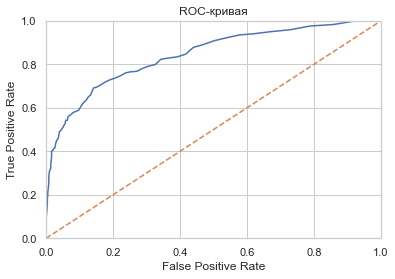

In [17]:
model = RandomForestClassifier(random_state=12345)
f1_RF_unbalanced, auc_RF_unbalanced = function_name(model, features_train, target_train, features_valid, target_valid)

## Борьба с дисбалансом

Сбалансируем данные и проверим качество прогноза на той же модели:

In [18]:
# увеличим выборку за счет сравнения класса "1" с классом "0"
def upsample(features, taret, repeat):
    features_zeroes = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeroes = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    features_upsampled = pd.concat([features_zeroes] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeroes] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [19]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Логистическая регрессия

In [20]:
# подберем порог классификации на новой тренировочной выборке
result_f1_lg = 0
threshold_f1_lg = 0
best_model_lg = None
auc = 0
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
auc_lg = roc_auc_score(target_valid, probabilities_one_valid)
    
for thershold in np.arange(0.01, 0.99, 0.02):
    predicted_valid = probabilities_one_valid > thershold
    f1 = f1_score(target_valid, predicted_valid)
    if result_f1_lg < f1:
        result_f1_lg = f1
        threshold_f1_lg = thershold
        best_model_lg = model 
        auc = auc_lg
print("Порог=", threshold_f1_lg, "F1=", result_f1_lg, "ROC-AUC=", auc)    

Порог= 0.20999999999999996 F1= 0.4161290322580646 ROC-AUC= 0.6727947180904797


In [21]:
# подберем порог классификации на увеличенной выборке при взвешивании классов
result_f1_lg = 0
threshold_f1_lg = 0
best_model_lg = None
auc = 0

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
auc_lg = roc_auc_score(target_valid, probabilities_one_valid)

for thershold in np.arange(0.01, 0.99, 0.02):
    predicted_valid = probabilities_one_valid > thershold
    f1 = f1_score(target_valid, predicted_valid)
    
    if result_f1_lg < f1:
        result_f1_lg = f1
        threshold_f1_lg = thershold
        best_model_lg = model 
        auc = auc_lg
print("Порог=", threshold_f1_lg, "F1=", result_f1_lg, "ROC-AUC=", auc)  

Порог= 0.5499999999999999 F1= 0.4655493482309125 ROC-AUC= 0.7203860415318263


'F1-мера, объединяющая полноту и точность, составила:'

0.4505183788878417

'Построим матрицу ошибок:'

array([[1178,  404],
       [ 179,  239]], dtype=int64)

'Ошибочных предсказаний'

583

'Верных предсказаний'

1417

'В'

41.14326040931545

'% случаев модель ошибается.'

'ROC-AUC ='

0.7132694971539871

'Построим ROC-кривую:'

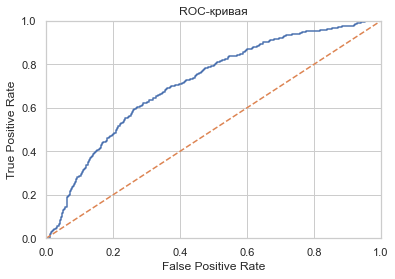

In [22]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
f1_LR_all_param, auc_LR_all_param = function_name(model, features_upsampled, target_upsampled, features_valid, target_valid, 0.5499999999999999)

Попробуем каждый параметр использовать по отдельности и сравнить результат:

#### Взвешивание классов 

'F1-мера, объединяющая полноту и точность, составила:'

0.44709626093874305

'Построим матрицу ошибок:'

array([[1024,  558],
       [ 137,  281]], dtype=int64)

'Ошибочных предсказаний'

695

'Верных предсказаний'

1305

'В'

53.25670498084291

'% случаев модель ошибается.'

'ROC-AUC ='

0.7132694971539871

'Построим ROC-кривую:'

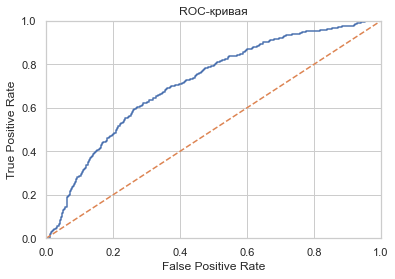

In [23]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
f1_LR_class, auc_LR_class = function_name(model, features_train, target_train, features_valid, target_valid)

#### Upsampling

'F1-мера, объединяющая полноту и точность, составила:'

0.44728434504792336

'Построим матрицу ошибок:'

array([[1028,  554],
       [ 138,  280]], dtype=int64)

'Ошибочных предсказаний'

692

'Верных предсказаний'

1308

'В'

52.90519877675841

'% случаев модель ошибается.'

'ROC-AUC ='

0.7131893490766337

'Построим ROC-кривую:'

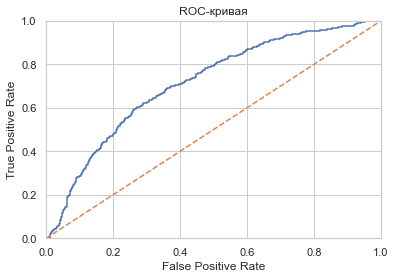

In [24]:
model = LogisticRegression(random_state=12345)
f1_LR_upsampled, auc_LR_upsampled = function_name(model, features_upsampled, target_upsampled, features_valid, target_valid)

#### Порог классификации

'F1-мера, объединяющая полноту и точность, составила:'

0.4190938511326861

'Построим матрицу ошибок:'

array([[1023,  559],
       [ 159,  259]], dtype=int64)

'Ошибочных предсказаний'

718

'Верных предсказаний'

1282

'В'

56.00624024960999

'% случаев модель ошибается.'

'ROC-AUC ='

0.6736612246626219

'Построим ROC-кривую:'

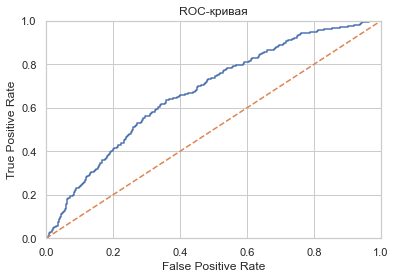

In [25]:
model = LogisticRegression(random_state=12345)
f1_LR_threshold, auc_LR_threshold = function_name(model, features_train, target_train, features_valid, target_valid, 0.20999999999999996)


Согласно F1-меры, ROC_AUC качество модели после сбалансирования стало выше за исключением использования порога классификации. Параметр, который дал лучший результат - взвешивание классов.

### Случайный лес

In [26]:
# подберем лучшие параметры на новой тренировочной выборке
best_model_rfc = None
best_f1_rfc = 0
max_depth_rfc = 0
n_estimators_rfc = 0
min_samples_leaf_rfc = 0
auc = 0
for est in range(1, 51, 5):
    for depth in range(1, 11):
        for min_samples in range(1, 5):
            model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, min_samples_leaf=min_samples, class_weight='balanced')
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result_f1 = f1_score(target_valid, predictions_valid)
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:,1]
            auc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
            if result_f1 > best_f1_rfc:
                best_model_rfc = model
                best_f1_rfc = result_f1
                max_depth_rfc = depth
                n_estimator_rfc = est
                min_samples_leaf_rfc = min_samples
                auc = auc_rfc
display("Максимальная глубина", max_depth_rfc, 
        "Количество деревьев", n_estimator_rfc, 
        "Mинимальное число объектов в листе", min_samples_leaf_rfc,
        "F1-мера =",best_f1_rfc,
        "ROC-AUC =", auc)

'Максимальная глубина'

9

'Количество деревьев'

46

'Mинимальное число объектов в листе'

4

'F1-мера ='

0.6331877729257642

'ROC-AUC ='

0.8537312710577731

#### Взвешивание классов 

'F1-мера, объединяющая полноту и точность, составила:'

0.6331877729257642

'Построим матрицу ошибок:'

array([[1374,  208],
       [ 128,  290]], dtype=int64)

'Ошибочных предсказаний'

336

'Верных предсказаний'

1664

'В'

20.192307692307693

'% случаев модель ошибается.'

'ROC-AUC ='

0.8537312710577731

'Построим ROC-кривую:'

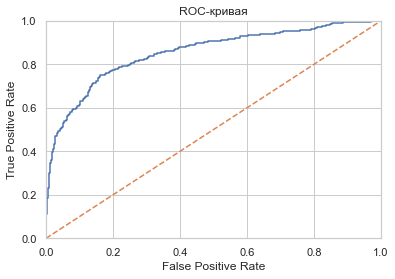

In [27]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4, class_weight='balanced')
f1_RF_class, auc_RF_class = function_name(model, features_train, target_train, features_valid, target_valid)

#### Upsampling

'F1-мера, объединяющая полноту и точность, составила:'

0.6187961985216472

'Построим матрицу ошибок:'

array([[1346,  236],
       [ 125,  293]], dtype=int64)

'Ошибочных предсказаний'

361

'Верных предсказаний'

1639

'В'

22.02562538133008

'% случаев модель ошибается.'

'ROC-AUC ='

0.8557742909163496

'Построим ROC-кривую:'

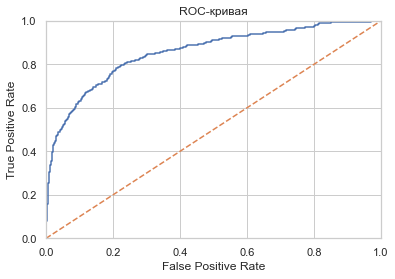

In [28]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4)
f1_RF_upsampled, auc_RF_upsampled = function_name(model, features_upsampled, target_upsampled, features_valid, target_valid)


#### Порог классификации

In [29]:
# рассчитаем F1-меру и ROC-AUC для порога классификации на тренировочной выборке без взвешивания классов
f1_RF_threshold = 0
threshold_f1_RF = 0
best_model_RF = None

model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
    
for thershold in np.arange(0.01, 0.99, 0.02):
    predicted_valid = probabilities_one_valid > thershold
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1_RF_threshold < f1:
        f1_RF_threshold = f1
        threshold_f1_RF = thershold
        best_model_RF = model 
        auc_RF_threshold = roc_auc_score(target_valid, probabilities_one_valid)
print("Порог=", threshold_f1_RF, "F1=", f1_RF_threshold, 'ROC-AUC =', auc_RF_threshold)

Порог= 0.29 F1= 0.6363636363636364 ROC-AUC = 0.8529630592974795


In [30]:
# рассчитаем порог для увеличенной выборки и взвешивания классов
f1_RF = 0
threshold_RF = 0
best_model_RF = None

model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
    
for thershold in np.arange(0.01, 0.99, 0.02):
    predicted_valid = probabilities_one_valid > thershold
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1_RF < f1:
        f1_RF = f1
        threshold_RF = thershold
        best_model_RF = model 
        auc_RF = roc_auc_score(target_valid, probabilities_one_valid)
print("Порог=", threshold_RF, "F1=", f1_RF, 'ROC-AUC =', auc_RF)


Порог= 0.57 F1= 0.63689776733255 ROC-AUC = 0.8523899249330082


#### Используем все параметры

'F1-мера, объединяющая полноту и точность, составила:'

0.63689776733255

'Построим матрицу ошибок:'

array([[1420,  162],
       [ 147,  271]], dtype=int64)

'Ошибочных предсказаний'

309

'Верных предсказаний'

1691

'В'

18.273211117681846

'% случаев модель ошибается.'

'ROC-AUC ='

0.8523899249330082

'Построим ROC-кривую:'

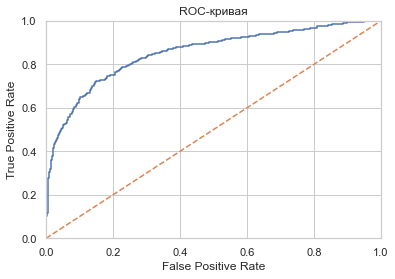

In [31]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4, class_weight='balanced')
f1_RF_all_param, auc_RF_all_param = function_name(model, features_upsampled, target_upsampled, features_valid, target_valid, 0.57)


Подберем лучшие гиперпараметры с помощью GridSearchCV

In [34]:
# подберем гиперпараметры
model_rf_GRID = RandomForestClassifier(class_weight='balanced', random_state=12345)
parametrs = { 'n_estimators': range (1, 51, 3),
              'max_depth': range (1,13, 1),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
gs = GridSearchCV(model_rf_GRID, param_grid=parametrs, scoring='f1', n_jobs=-1, cv=3)
gs.fit(features_train, target_train)

print('Гиперпараметры лучшей модели:', gs.best_params_) 
print('Значение f1:', gs.best_score_)

Гиперпараметры лучшей модели: {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 46}
Значение f1: 0.6223935844274827


Значение F1-меры с подобранными гиперпараметрами с помощью GridSearchCV меньше, 
чем подобранными вручную, в связи с нахождением меньшего количества гиперпараметров.

### Анализ моделей в зависимости от гиперпараметров

In [36]:
# сведем результаты F1-меры и ROC-AUC в одну таблицу для удобства
df_f1_auc = pd.DataFrame({
    '-': ['Несбалансированные', "Все параметры", "Взвешивание классов", "Upsampling", "Порог"], 
    'LR_F1': [f1_LR_unbalanced, f1_LR_all_param, f1_LR_class, f1_LR_upsampled, f1_LR_threshold],
    'LR_ROC-AUC': [auc_LR_unbalanced, auc_LR_all_param, auc_LR_class, auc_LR_upsampled, auc_LR_threshold],
    'RF_F1': [f1_RF_unbalanced, f1_RF_all_param, f1_RF_class, f1_RF_upsampled, f1_RF_threshold],
    'RF_ROC-AUC': [auc_RF_unbalanced, auc_RF_all_param, auc_RF_class, auc_RF_upsampled, auc_RF_threshold]})

print(df_f1_auc)

                     -     LR_F1  LR_ROC-AUC     RF_F1  RF_ROC-AUC
0   Несбалансированные  0.083857    0.672795  0.575712    0.843305
1        Все параметры  0.450518    0.713269  0.636898    0.852390
2  Взвешивание классов  0.447096    0.713269  0.633188    0.853731
3           Upsampling  0.447284    0.713189  0.618796    0.855774
4                Порог  0.419094    0.673661  0.636364    0.852963


Построим графики зависимости значений F1-меры и ROC-AUC:

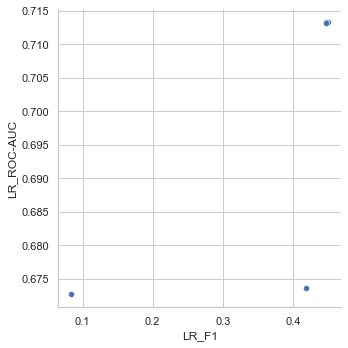

In [37]:
sns.relplot(x='LR_F1', 
                y='LR_ROC-AUC',
                data=df_f1_auc)

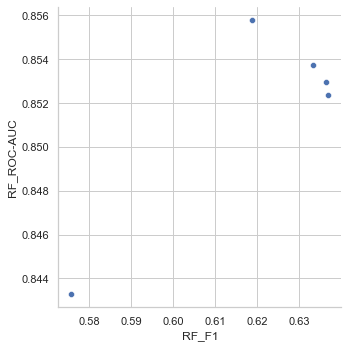

In [40]:
sns.relplot(x='RF_F1', 
                y='RF_ROC-AUC',
                data=df_f1_auc)

Из получившихся данных и их визуализации следует, что рост F1-меры влечет за собой рост значения ROC-AUC. Это значит, что чем больше значение F1-меры, тем точнее предсказание модели при заданных параметрах.

Самые большие значения F1-меры равны 0.636898 (при ROC-AUC=0.852390) и 0.636364 (при ROC-AUC=0.852963) у модели случайного леса при использовании всех параметров и порога классификации.

В следующем разделе на тестовой выборке попробуем каждый из этих параметров и их совокупность.

## Тестирование модели

### Случайный лес (все параметры)

'F1-мера, объединяющая полноту и точность, составила:'

0.60381861575179

'Построим матрицу ошибок:'

array([[1415,  162],
       [ 170,  253]], dtype=int64)

'Ошибочных предсказаний'

332

'Верных предсказаний'

1668

'В'

19.904076738609113

'% случаев модель ошибается.'

'ROC-AUC ='

0.8552462931232208

'Построим ROC-кривую:'

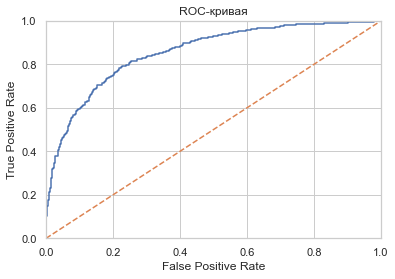

In [41]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4, class_weight='balanced')
F1_RF_class_test, auc_RF_class_test = function_name(model, features_upsampled, target_upsampled, features_test, target_test, 0.57)


### Случайный лес (порог классификации)

'F1-мера, объединяющая полноту и точность, составила:'

0.611353711790393

'Построим матрицу ошибок:'

array([[1364,  213],
       [ 143,  280]], dtype=int64)

'Ошибочных предсказаний'

356

'Верных предсказаний'

1644

'В'

21.65450121654501

'% случаев модель ошибается.'

'ROC-AUC ='

0.8576838147663443

'Построим ROC-кривую:'

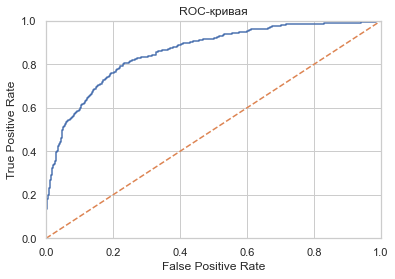

In [42]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=46, min_samples_leaf=4)
f1_RF_threshold_test, auc_RF_threshold_test = function_name(model, features_train, target_train, features_test, target_test, 0.26999999999999996)


In [44]:
# сведем результаты F1-меры и ROC-AUC в одну таблицу для удобства
df_f1_auc_test = pd.DataFrame({
    '-': ["Все параметры", "Порог классификации"], 
    'F1-мера': [F1_RF_class_test, f1_RF_threshold_test],
    'ROC-AUC': [auc_RF_class_test, auc_RF_threshold_test]})

print(df_f1_auc_test)

                     -   F1-мера   ROC-AUC
0        Все параметры  0.603819  0.855246
1  Порог классификации  0.611354  0.857684


**За счет сбалансирования выборки и подбора лучших параметров все модели (логистическая регрессия, дерево решений, случайный лес) увеличили показатель F1-меры и ROC-AUC. Лучшей моделью на тестовой выборке оказалась модель случайного леса, на увеличение метрик которой влияет взвешивание классов, порог классификации и увеличение выборки. Удалось добиться значения F1-меры = 0.618690 при AUC-ROC = 0.855246. В 19.9% случаев данная модель ошибается на тестовых данных.**